In [1]:
import fiona
import pandas as pd
import geopandas as gpd
from nansat import Nansat
import numpy as np

import rasterio as rio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Opening all images manually
src_ndwi = '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif'
src_awei = '/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif'
src_bands = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
src_vis = '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif'

ndwi = Nansat(src_ndwi)
awei = Nansat(src_awei)
raw_bands = Nansat(src_bands)
vis = Nansat(src_vis)

In [3]:
# Stack as multi-dimensional np array
all_bands = [raw_bands[band_n] for band_n in raw_bands.bands().keys()]
all_bands.append(ndwi[1])
all_bands.append(awei[1])
for band_n in vis.bands().keys():
    all_bands.append(vis[band_n])
lon_grd, lat_grd = ndwi.get_geolocation_grids()

In [4]:
arr_all_bands = np.array(all_bands)

all_bands.append(lon_grd)
all_bands.append(lat_grd)

gridded_all_bands = np.array(all_bands)

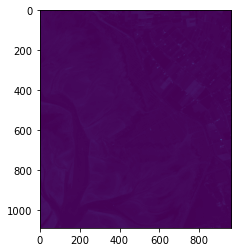

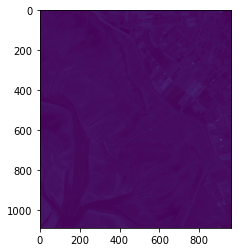

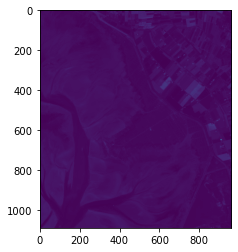

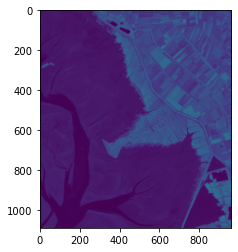

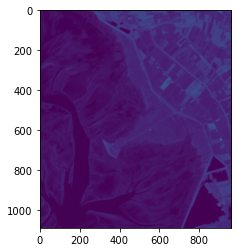

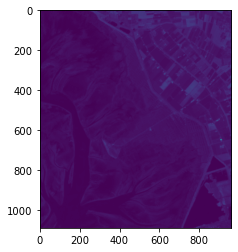

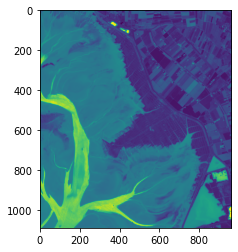

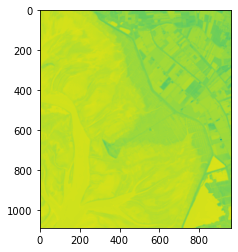

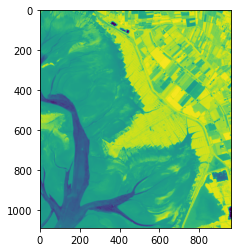

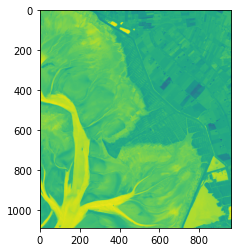

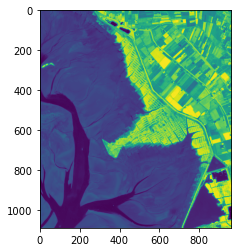

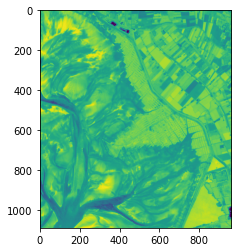

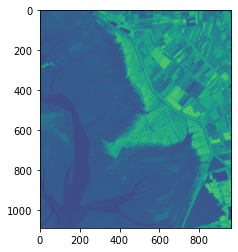

In [5]:
for i in range(arr_all_bands.shape[0]):
    plt.figure()
    plt.imshow(arr_all_bands[i, :, :])

In [6]:
### masking land with aoi shapefile
#with fiona.open('/container_dir1/subsets/aoi.shp') as shapefile:
#    shapes = [feature["geometry"] for feature in shapefile]
#with rio.open('/container_dir1/results/STACK.tif') as src4:
#    out_image, transformed = rio.mask.mask(src4, shapes, crop=True, filled=True)
#    out_meta = src4.meta

### Export masked image
# masked_path = '/container_dir1/results/aoi_rasterstack.tif'

In [7]:
### now import new set of trainig points with more points, extract pixel values of the raster stack at the point locations and add them to table of points
### but for that we need to know which band displays what, so I have to add correct titles to raster stack bands

src_t_points = '/container_dir1/subsets/t_points_new2.shp'
points = gpd.read_file(src_t_points)

In [8]:
class_names = points['classtxt'].unique()
print(class_names)
points

['water' 'structures' 'seabed' 'lsm' 'pioneer' 'usm']


,id,classid,classtxt,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,geometry
0,None,1,water,0,0,0,0.000000,42.297056,8.784622,54.564908,POINT (486073.904 6046397.927)
1,None,1,water,1,0,1,9.984770,42.297056,8.784725,54.564975,POINT (486080.623 6046405.312)
2,None,1,water,2,0,2,19.969540,42.297056,8.784829,54.565041,POINT (486087.343 6046412.697)
3,None,1,water,3,0,3,29.954310,42.297056,8.784933,54.565108,POINT (486094.062 6046420.083)
4,None,1,water,4,0,4,39.939081,42.297056,8.785036,54.565175,POINT (486100.782 6046427.468)
...,...,...,...,...,...,...,...,...,...,...,...
14140,None,5,lsm,29,0,29,278.934684,312.978635,8.833388,54.609927,POINT (489238.936 6051398.693)
14141,None,5,lsm,30,0,30,288.683150,312.978635,8.833277,54.609987,POINT (489231.804 6051405.338)
14142,None,5,lsm,31,0,31,298.431617,312.978635,8.833167,54.610047,POINT (489224.672 6051411.984)
14143,None,5,lsm,32,0,32,308.180083,312.978635,8.833056,54.610106,POINT (489217.540 6051418.630)


In [9]:
# create new working gdf with only the interesting columns and without the qgis stuff in original table
points2 = points[['classid', 'classtxt', 'geometry', 'x', 'y']].copy()

# Rename x and y to lon and lat
points2.rename(columns={'x':'lon', 'y':'lat'}, inplace=True)
points2

,classid,classtxt,geometry,lon,lat
0,1,water,POINT (486073.904 6046397.927),8.784622,54.564908
1,1,water,POINT (486080.623 6046405.312),8.784725,54.564975
2,1,water,POINT (486087.343 6046412.697),8.784829,54.565041
3,1,water,POINT (486094.062 6046420.083),8.784933,54.565108
4,1,water,POINT (486100.782 6046427.468),8.785036,54.565175
...,...,...,...,...,...
14140,5,lsm,POINT (489238.936 6051398.693),8.833388,54.609927
14141,5,lsm,POINT (489231.804 6051405.338),8.833277,54.609987
14142,5,lsm,POINT (489224.672 6051411.984),8.833167,54.610047
14143,5,lsm,POINT (489217.540 6051418.630),8.833056,54.610106


In [10]:
arrays_flat = [gridded_all_bands[i, :, :].flatten() for i in range(gridded_all_bands.shape[0])] 

raster_df = pd.DataFrame({
    "B2" : arrays_flat[0],
    "B3" : arrays_flat[1],
    "B4" : arrays_flat[2],
    "B8" : arrays_flat[3],
    "B11" : arrays_flat[4],
    "B12" : arrays_flat[5],
    "NDWI" : arrays_flat[6],
    "AWEI" : arrays_flat[7],
    "NDVI" : arrays_flat[8],
    "SAVI" : arrays_flat[9],
    "MSAVI" : arrays_flat[10],
    "NDMI" : arrays_flat[10],
    "EVI" : arrays_flat[11],
#    "?" : arrays_flat[12],
    "lon" : arrays_flat[13],
    "lat" : arrays_flat[14]
})
    
raster_df.head()

,B2,B3,B4,B8,B11,B12,NDWI,AWEI,NDVI,SAVI,MSAVI,NDMI,EVI,lon,lat
0,157.0,335.0,284.0,1009.0,445.0,271.0,-0.501488,-0.143750,0.560712,2.498808,0.193002,0.193002,0.387895,8.760486,54.661582
1,183.0,320.0,273.0,1019.0,373.0,229.0,-0.522031,-0.109650,0.577399,2.502543,0.195318,0.195318,0.464080,8.760641,54.661582
2,193.0,355.0,315.0,930.0,373.0,229.0,-0.447471,-0.093425,0.493976,2.500400,0.176438,0.176438,0.427475,8.760796,54.661583
3,229.0,421.0,375.0,873.0,340.0,208.0,-0.349304,-0.046625,0.399038,2.480474,0.163394,0.163394,0.439406,8.760952,54.661583
4,195.0,379.0,350.0,846.0,340.0,208.0,-0.381224,-0.062750,0.414716,2.500968,0.158798,0.158798,0.426644,8.761107,54.661583


In [11]:
sorted_points2 = points2.sort_values(by=['lon'] , axis=0, ascending=True)
sorted_raster_df = raster_df.sort_values(by=['lon'] , axis=0, ascending=True)

In [12]:
merged_sorted_df = pd.merge_asof(left=sorted_points2, right=sorted_raster_df, on=['lon'], direction='nearest')

In [13]:
gdf = gpd.GeoDataFrame(
    merged_sorted_df, geometry=merged_sorted_df.geometry)
gdf.drop(columns=['lat_y'])
gdf.head()

,classid,classtxt,geometry,lon,lat_x,B2,B3,B4,B8,B11,B12,NDWI,AWEI,NDVI,SAVI,MSAVI,NDMI,EVI,lat_y
0,1,water,POINT (484619.587 6048343.796),8.762028,54.582354,168.0,376.0,267.0,1426.0,805.0,444.0,-0.582686,-0.32935,0.684584,2.414314,0.275981,0.275981,0.278351,54.610000
1,1,water,POINT (484622.977 6048334.669),8.762081,54.582272,655.0,858.0,902.0,1144.0,1046.0,718.0,-0.142857,-0.30125,0.118280,2.163213,0.200592,0.200592,0.044749,54.600923
2,1,water,POINT (484626.367 6048325.542),8.762134,54.582190,512.0,761.0,758.0,1064.0,1041.0,688.0,-0.166027,-0.32780,0.167947,2.243623,0.189422,0.189422,0.010926,54.591846
3,1,water,POINT (484629.757 6048316.415),8.762187,54.582108,320.0,619.0,399.0,4792.0,1333.0,822.0,-0.771207,-0.63145,0.846272,1.902954,0.877182,0.877182,0.564735,54.635883
4,1,water,POINT (484633.147 6048307.288),8.762240,54.582026,547.0,731.0,830.0,1068.0,234.0,140.0,-0.187326,0.13360,0.125395,2.209046,0.188044,0.188044,0.640553,54.626806


In [15]:
### Export geodataframe as trainingpoints for classification
gdf.to_file('/container_dir1/results/gdf_train_pixelvalues.shp', mode='w')

In [43]:
### Pixel values with geopandas
coord_list = [(x,y) for x,y in zip(points2['geometry'].x , points2['geometry'].y)]

#list_tifs =  [src_ndwi, src_awei, src_bands, src_vis]
# names = [rio_ndwi, rio_awei, rio_bands, rio_vis]
#for i in len(list_tifs):
#    with rio.open(list_tifs[i]) as names(i)

## when opening stacked tif:
#open raster, call sample values
#with rasterio.open(fp_raster,'r') as src: 
#    samplevalues = [x for x in src.sample(coord_list)]

rio_ndwi = rio.open(src_ndwi)
rio_awei = rio.open(src_awei)
rio_bands = rio.open(src_bands)
rio_vis = rio.open(src_vis)

gdf['ndwi'] = [x for x in rio_ndwi.sample(coord_list)]
gdf['awei'] = [x for x in rio_awei.sample(coord_list)]
gdf['value_bands'] = [x for x in rio_bands.sample(coord_list)]
#gdf['value_bands'] = [x for x in rio_bands[1].sample(coord_list)]
gdf['value_vis'] = [x for x in rio_vis.sample(coord_list)]

gdf.drop(columns=['lon','lat_x','lat_y'])
gdf.head()

,classid,classtxt,geometry,lon,lat_x,B2,B3,B4,B8,B11,...,NDVI,SAVI,MSAVI,NDMI,EVI,lat_y,ndwi,awei,value_bands,value_vis
0,1,water,POINT (484619.587 6048343.796),8.762028,54.582354,168.0,376.0,267.0,1426.0,805.0,...,0.684584,2.414314,0.275981,0.275981,0.278351,54.610000,[0.44288576],[0.035224993],"[248, 360, 200, 139, 167, 140]","[-0.179941, 2.7980895, 0.022683946, -0.0915032..."
1,1,water,POINT (484622.977 6048334.669),8.762081,54.582272,655.0,858.0,902.0,1144.0,1046.0,...,0.118280,2.163213,0.200592,0.200592,0.044749,54.600923,[0.44268772],[0.0382],"[255, 365, 225, 141, 161, 145]","[-0.2295082, 2.7797241, 0.022445843, -0.066225..."
2,1,water,POINT (484626.367 6048325.542),8.762134,54.582190,512.0,761.0,758.0,1064.0,1041.0,...,0.167947,2.243623,0.189422,0.189422,0.010926,54.591846,[0.3942857],[0.038150005],"[236, 366, 248, 159, 161, 145]","[-0.2186732, 2.7577214, 0.025438169, -0.006249..."
3,1,water,POINT (484629.757 6048316.415),8.762187,54.582108,320.0,619.0,399.0,4792.0,1333.0,...,0.846272,1.902954,0.877182,0.877182,0.564735,54.635883,[0.48669198],[0.046324994],"[203, 391, 240, 135, 165, 148]","[-0.28, 2.7711627, 0.0208721, -0.09999999, -0...."
4,1,water,POINT (484633.147 6048307.288),8.762240,54.582026,547.0,731.0,830.0,1068.0,234.0,...,0.125395,2.209046,0.188044,0.188044,0.640553,54.626806,[0.4201835],[0.04925],"[257, 387, 238, 158, 155, 144]","[-0.20202024, 2.765011, 0.025494339, 0.0095846..."


In [39]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [16]:
### Export geodataframe as trainingpoints for classification
gdf.to_file('/container_dir1/results/gdf_train_pixelvalues_gdp.shp', mode='w')
### sth in the file is a np array (and those lists of values from rio.sample are also not practical), find it and change to type numeric

In [40]:
#### Export stacked raster for class prediction

#with rio.open('/container_dir1/results/all_bands.tif', 'w', **meta) as dst:
#    for band_nr, src in enumerate(arr_all_bands, start=1):
#        dst.write_band(band_nr, src) 

NameError: name 'meta' is not defined